# Neural Style Transfer Project


**Neural Style Transfer** is a technique discussed in paper [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576) which *introduces an artificial system based on a Deep Neural Network that creates artistic images of high perceptual quality. The system uses neural representations to separate and recombine content and style of arbitrary images, providing a neural algorithm for the creation of artistic images*. 
In simple terms, **Neural Style transfer** is a computer vision topic for stylization that takes two images: a content image and a style reference image, and blends them together so that the resulting output image retains the core elements of the content image, but appears to be painted in the style of the style reference image. This stylization heavily depended on the CNN under study and is more customizatable than CycleGAN *(according to the [blog](https://medium.com/analytics-vidhya/neural-style-transfer-vs-cyclegan-6de063abe698))*.

This project main focus is to take advantage of the customization provided by this technique to generate an image that looks as though painted by a famous artist.

**Note:** This project is partially inspired from [TensorFlow's Neural Style Transfer Documentation](https://www.tensorflow.org/tutorials/generative/style_transfer) and [Assignment in TensorFlow: Advanced Techniques Specialization - Coursera](https://www.coursera.org/specializations/tensorflow-advanced-techniques).

**What will be covered?**


*   Importing the Data *(content and style images)*.
*   Choosing a model architecture to generate stylized images.
*   Preprocessing the Data.
*   Exploring the Data *(optional: for the sake of audience)*
*   Creating custom loss functions.
*   Utilizing TensorFlow's [Gradient Tape](https://www.tensorflow.org/api_docs/python/tf/GradientTape) to update the stylized image.
*   Using Adam's optimizer instead of LBFGS *(as it also works fine)*.
*   Saving the results in `.gif` format.

In [3]:
# check the Google Colab's GPU
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-fbaf092c-4f41-f341-828d-9f90dda877a2)


## Importing the Essential Libraires


In [1]:
# import the essential libraries
import os
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
from imageio import mimsave
from IPython.display import display as display_fn
from IPython.display import Image
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

## Importing the data

The data will consists of Content and Style images.

In [2]:
# copy content and style images to the current runtime
# !cp -r "/content/drive/MyDrive/Portfolio/Neural Style Transfer/data" "/content/"

In [3]:
# check the number of content and style images
content_images = os.listdir("./data/content_images")
style_images = os.listdir("./data/style_images")

print(f"Number of Content Images: {len(content_images)}")
print(f"Number of Style Images: {len(style_images)}")

Number of Content Images: 8
Number of Style Images: 10


## Importing the Model Architecture

**VGG-19** is already proven to work with neural style transfer as it's a straight forward network. But in this project, **Inception** architecture will be used to generate the stylized image.

### Choosing Content and Style Layers


On the other hand, the output layers *(to calculate the losses)* that needs to get chosen have a significant customizable affect on the resulting stylized output image. The earlier layers have the capability to capture the lower level feature while to capture higher level features, it is required that deeper layers are used. To understand how to choose the layers, it is better to get to know about the Style and Content Loss.

There is only one architecuture to calculate the content representations, style representations and stylized Image representations. Furthermore, the image generation takes place during the optimization stage *(where every parameter is frozen except the image)* rather than at the regular outputs of the ANNs.

**Style and Content Loss** plays a main role in the stylization of the content image. Style and Content Loss has two parts, i.e. content loss and style loss. So, these are first seperately calculated then combined along with their respective weights to determine the total loss. The optimizer then uses the total loss to optimize the trainable parameters which in this case is the image *(other model parameters are frozen)*.

As it was discussed earlier, that how the CNN feature maps captures the feature at different depths of the architecture, then by intuition, it is required that we use a base feature map for content image at a deeper depth *(CNN layer)* where the main content of the image is highlighted, and choose a lower to middle depth layers for the base representations for the style image to get the middle level features for stylization of the main content in the content image.

These style and content representations are then used along with the respective representations of the image that is to be generated, i.e. content image. Those style representations will make sure that there is stylization features and content representation will assure that the content image doesn't lose it's main content features. So, the already content image for stylization, generates new parameters only for the image during the optimization step after calculating the style and content loss.

**Style Loss:**
 Style Images have the required style that is to be pasted onto the content image to produce a stylized image. Therefore, it is required to carefully choose the layers such that to get either the lower or higher level features of the stylized image. Those features are then used for stylization.

In this project, **earlier to middle layers** were used to calculate the style loss. These 5 layers' representations/features correlation are then given by the Gram Matrix. 
As 5 layers are used, we need to calculate the style loss (using the Gram Matrices from both original and generated image features), the formula from the paper is used,



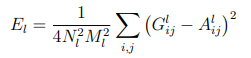



where **N<sub>L</sub>** is the number of feature maps each of size **M<sub>L</sub>**, **M<sub>L</sub>** is the height times width of those individual feature maps of layer **L** the total **style loss** is calculated with the customizable style weight **w<sub>L</sub>** *(in simple words, is the contribution of each layer)* as,

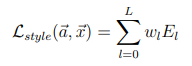

**Content Loss:**
 Content representations needs to be from the deeper layer (just before the deepest) of the model architecture to conserve the main features of the image during image stylization. After getting the desired layer, the content loss is calculated by comparing the original representations against the generated image's representations which are given by,

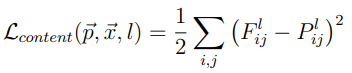

where **F<sup>L</sup> <sub>ij</sub>** is the activation *(of the original content image representations)* **i<sup>th</sup>** filter at position **j** in layer **L**. The same goes for **P<sup>L</sup> <sub>ij</sub>** but it's for the stylized image features.

So let **p** be the photograph, **a** be the artwork and **x** be the inital image. The loss function
we minimise is,

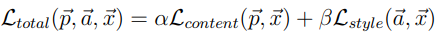

where **α** and **β** are the weighting factors for content and style reconstruction respectively.

In [4]:
# get output layer names to calculate content and style features & losses
def get_layer_names():
    '''get the layers to extract the features of the model'''

    content_layers = ['conv2d_88']

    style_layers = ['conv2d_3',
                  'conv2d_7',
                  'conv2d_14',
                  'conv2d_21',
                  'conv2d_29']

    return style_layers + content_layers

In [5]:
# function to get inception model to get content and style features
def get_model(output_layers_names):
    '''get the model to extract content and style features'''

    module = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
    # parameters are frozen
    module.trainable = False
    # get layers' outputs
    outputs = [module.get_layer(layer).output for layer in output_layers_names]
    # create a functional api model
    model = tf.keras.Model(inputs=module.inputs, outputs=outputs)

    return model

# create the model
model = get_model(get_layer_names())

2022-12-09 15:38:51.298780: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 15:38:51.421896: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 15:38:51.422676: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 15:38:51.424478: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

87924736/87910968 [==============================] - 0s 0us/step


In [6]:
# output layers of the `model`
model.outputs

[<KerasTensor: shape=(None, None, None, 80) dtype=float32 (created by layer 'conv2d_3')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'conv2d_7')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'conv2d_14')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'conv2d_21')>,
 <KerasTensor: shape=(None, None, None, 96) dtype=float32 (created by layer 'conv2d_29')>,
 <KerasTensor: shape=(None, None, None, 384) dtype=float32 (created by layer 'conv2d_88')>]

**The optimizer LBFGS is recommended by the paper, but Adam works fine too.**

In [7]:
# get the optimizer
optimizer = tf.optimizers.Adam(
                  tf.keras.optimizers.schedules.ExponentialDecay(
                      initial_learning_rate=80.0, decay_steps=100, decay_rate=0.80    # inital learning rate is set to 80 and then decays at the rate of `0.8/100steps`.
                  )
              )

## Generation of Stylized Image

### Code Development

The main points during the code development to take under consideration are as follows:


*   Inception model expects the input to be in `[-1, 1]` range.
*   The model is expected to have its paramters frozen i.e `model.trainable = False`.
*   Style and Content Loss is calculated as per previous section which then gets us the gradients to optimize the image paramters.
*   After every optimization step, the stylized image will have its parameters overgrown at unknown degree. To cope-up with it, clipping is done to let these parameters be in range `[0., 255.]` which is then preprocessed to get it into [-1, 1] range for it to be fed again into the model. This process is repeated as required.




In [8]:
class NeuralStyleTransfer():
    """This object preprocesses the data and can generate the stylized image."""
    def __init__(self,
               model=model,
               num_style_layers=None,
               num_content_layers=None,
               optimizer=optimizer,
               content_image=None,
               style_image=None,
               style_weight=None,
               content_weight=None,
               total_variation_weight=None):

        self.content_path = f".data/content_images/content_img_{content_image}.jpg"
        self.style_path = f"./data/style_images/style_img_{style_image}.jpg"
        self.sw = style_weight
        self.cw = content_weight
        self.tvw = total_variation_weight
        self.model = model
        self.NUM_STYLE_LAYERS=num_style_layers
        self.NUM_CONTENT_LAYERS=num_content_layers
        self.optimizer = optimizer


    # function to create tensors from image
    def img_to_tensors(self, path):
        '''loads image from `path` and converts it into tensors.'''
        img = tf.io.read_file(path)
        img = tf.io.decode_image(img)
        img = tf.cast(img, tf.float32)
        return img

    # resizes the image to `(shape, shape, 3)`
    def resize_img_tensors(self, img_tensors, shape=450):
        '''resize and crops the image (tensors) to aspect-ratio to have a shape of `(450, 450, 3)`.'''

        resizing_layer = tf.keras.layers.Resizing(
                            shape,
                            shape,
                            interpolation='bilinear',
                            crop_to_aspect_ratio=True,
                          )
        resized_img = resizing_layer(img_tensors, training=True)
        return resized_img

    # displays image from image tensors
    def show_img(self, img_tensors, title="img", normalized=False):
        '''displays the image from image tensors'''
        plt.title(f"{title}")
        plt.axis("off")
        if normalized:
            plt.imshow(tf.cast(img_tensors*255., tf.uint8))
        else:
            plt.imshow(tf.cast(img_tensors, tf.uint8))

    # function to clip the image tensors to have values between (0., 255.) during neural style transfer
    def clip_img_tensors(self, img_tensors):
        '''clips the image tensors to have values between (0., 255.) during neural style transfer'''
        return tf.clip_by_value(img_tensors, clip_value_min=0., clip_value_max=255.)

    # preprocessing function to load image into tensors, and set those tensors between (-1, 1)
    def preprocess_input(self, path):
        '''preprocesses raw image to `tf.float32` tensors of shape (1, 450, 450, 3)'''
        img_tensors = self.img_to_tensors(path)
        resized_img = self.resize_img_tensors(img_tensors)
        img = (resized_img / 127.5) - 1
        return img[tf.newaxis, :]

    def preprocess_generated_img(self, path):
        '''preprocesses the image that gets updated by the model for the style transfer'''
        img_tensors = self.img_to_tensors(path)
        resized_img = self.resize_img_tensors(img_tensors)
        return resized_img[tf.newaxis, :]

    # explore content images
    def show_content_images(self):
        '''imports and displays content images.'''
        plt.figure(figsize=(20, 10))
        for i in range(8):
            img = self.resize_img_tensors(self.img_to_tensors(f"./data/content_images/content_img_{i+1}.jpg"))
            plt.subplot(2, 4, i+1)
            self.show_img(img, title=f"{i+1}. Content Image")

    # explore style images
    def show_style_images(self):
        '''imports and displays content images.'''
        plt.figure(figsize=(20, 8))
        for i in range(10):
            img = self.resize_img_tensors(self.img_to_tensors(f"./data/style_images/style_img_{i+1}.jpg"))
            plt.subplot(2, 5, i+1)
            self.show_img(img, title=f"{i+1}. Style Image")


    def gram_matrix_features(self, input_tensor):
        """ Calculates the gram matrix and scale it"""

        # calculate the gram matrix of the input tensor
        gram = tf.linalg.einsum('abcd,abce->ade', input_tensor, input_tensor) 

        # get the height and width of the gram matrix and get a scaling factor
        input_shape = tf.shape(input_tensor)
        scale_factor = 1 / (tf.cast(input_shape[1] * input_shape[2], tf.float32))

        # scale the gram matrix by dividing by the number of locations
        scaled_gram = gram * scale_factor

        return scaled_gram

    def style_image_features(self, image, preprocessed=False):  
        """ Get the style image features """

        # preprocess if mentioned
        if not preprocessed:
            preprocessed_style_image = self.preprocess_input(image)
            outputs = self.model(preprocessed_style_image)

        # get output from the model
        else:
            outputs = self.model(image/127.5 - 1)

    # Get just the style feature layers (exclude the content layer)
    style_outputs = outputs[:self.NUM_STYLE_LAYERS]

    # for each style layer, calculate the gram matrix for that layer and store these results in a list
    gram_style_features = [self.gram_matrix_features(style_layer) for style_layer in style_outputs]
                          
    return gram_style_features

    def content_image_features(self, image, preprocessed=False):
        """ Get the content image features """

        # get outputs from preprocessed input
        if preprocessed:
            outputs = self.model(image/127.5 - 1)

    else:
      # preprocess the image
      preprocessed_content_image = self.preprocess_input(image)
        
      # get the outputs from the model
      outputs = self.model(preprocessed_content_image)

    # get the content layer of the outputs
    content_outputs = outputs[self.NUM_STYLE_LAYERS:]

    ### END CODE HERE ###
    return content_outputs

    # get style loss
    def style_loss(self, features, target_features):
        '''takes the style image features along with its target to calculate style loss.'''
        loss = tf.reduce_mean(tf.square(features - target_features))

        return loss

    # get content loss
    def content_loss(self, features, target_features):
        '''takes the content image features along with its target to calculate content loss.'''
        loss = tf.reduce_sum(tf.square(features - target_features))

        return 0.5 * loss

    # get total loss
    def total_loss(self, gen_image, style_gen_features, style_targets, content_gen_features, content_targets, style_weight, content_weight, total_variation_weight):
        '''takes the respective features representations along with their weights to calculate total loss.'''
        # Sum of the style losses
        s_loss = style_weight * tf.add_n([self.style_loss(style_gen_feature, style_target) for style_gen_feature, style_target in zip(style_gen_features, style_targets)]) / len(style_targets)

        # Sum up the content losses
        c_loss = content_weight * tf.add_n([self.content_loss(content_gen_feature, content_target) for content_gen_feature, content_target in zip(content_gen_features, content_targets)]) / len(content_targets)

        tot_variation = total_variation_weight * tf.image.total_variation(gen_image)

        tot_loss = s_loss + c_loss + tot_variation

        return tot_loss

    # function for a single image generation step
    def generation_step(self, optimizer, gen_image, style_targets, content_targets, style_weight, content_weight, total_variation_weight):
        '''take gradients with respect to the generated image and update the generated image whose tensors get clipped (0., 255.)'''

        with tf.GradientTape() as tape:

            style_gen_features = self.style_image_features(gen_image, preprocessed=True)                           

            content_gen_features = self.content_image_features(gen_image, preprocessed=True)                                

            loss = self.total_loss(gen_image, style_gen_features, style_targets, content_gen_features, content_targets, style_weight, content_weight, total_variation_weight)

        gradients = tape.gradient(loss, gen_image)

        optimizer.apply_gradients([(gradients, gen_image)])

        gen_image.assign(self.clip_img_tensors(gen_image))

    # function for neural style transfer
    def style_transfer(self, optimizer, style_img_path, content_img_path, style_weight, content_weight, total_variation_weight, epochs, steps_per_epoch):

        style_targets = self.style_image_features(style_img_path)

        content_targets = self.content_image_features(content_img_path)

        gen_image = tf.Variable(self.preprocess_generated_img(content_img_path))

        plt.figure(figsize=(7, 7))
        plt.imshow(tf.cast(tf.squeeze(gen_image), tf.uint8))
        plt.axis("off")
        plt.title("Original Image")
        plt.show()

        gen_img_tensors = []
        gen_img_tensors.append(tf.squeeze(gen_image))

        for epoch in range(epochs):
            print("\nEpoch {}: ".format(epoch+1), end="")
            for step in tqdm(range(steps_per_epoch)):

                self.generation_step(optimizer, gen_image, style_targets, content_targets, style_weight, content_weight, total_variation_weight)

            img = tf.squeeze(gen_image[:])
            gen_img_tensors.append(img)

            plt.figure(figsize=(7, 7))
            # plt.subplot(epochs, 3, epoch+1)
            plt.imshow(tf.cast(img, tf.uint8))
            plt.axis("off")
            plt.show()

        generated_image = tf.cast(gen_image, dtype=tf.uint8)

        return generated_image, gen_img_tensors

    def generate(self, epochs=None, steps_per_epoch=None):
        '''This function takes the epochs and steps_per_epoch as parameters and starts generating stylized image which is then displayed.'''
        stylized_image, gen_img_tensors = self.style_transfer(self.optimizer, self.style_path, self.content_path,
                                                              self.sw, self.cw, self.tvw,
                                                              epochs=epochs, steps_per_epoch=steps_per_epoch)
        return stylized_image, gen_img_tensors


    def display_gif(self, gif_path):
        '''displays the generated images as an animated gif'''
        with open(gif_path,'rb') as f:
            display_fn(Image(data=f.read(), format='png'))

    def create_gif(self, gif_path, images):
        '''creates animation of generated images'''
        mimsave(gif_path, images, fps=2)
        return gif_path

    def create_display_gif(self, gen_images, save_path):
        '''creates, saves and displays the gif.'''
        gif_images = [np.array(tf.cast(i, tf.uint8)) for i in gen_images]
        gif_path = self.create_gif(save_path, gif_images)
        self.display_gif(save_path)

### `NeuralStyleTransfer` Object

The class `NeuralStyleTransfer` is initialized with the following parameters.

*  `model`: the model that will be used to get the style and content loss. *Also, the outputs are expected to be in the following arrangement (Style outputs + Content outputs)*.
*  `num_style_layers`: number of style layers used to get style representation.
*  `num_content_layers`: number of content layers used to get content representation.
*  `optimizer`: optimizer that is used for stylizing the image.
*  `content_image`: number of the content image i.e. 1, 2, 3, ... etc. *It is expected the raw image name to be in a format "content_img_1", "content_img_2").
*  `style_image`: number of the style image i.e. 1, 2, 3, ... etc. *It is expected the raw image name to be in a format "style_img_1", "style_img_2").
*  `style_weight`: contribution of the style representations usually in range (1.0, 1e<sup>-2</sup>).
*  `content_weight`: contribution of the content representations usually in range (1e<sup>-5</sup>, 1e<sup>-20</sup>).
*  `total_variation_weight`: it is not discussed earlier but in simple words, high the high-frequency artifacts, higher the total variation loss. To reduce these high-frequency artifacts which produce noise, total_variation_weight is used which is a contribution parameter of total variation reduction.

In [11]:
# create an instance of the NeuralStyleTransfer for any content and style image
nst = NeuralStyleTransfer(model=model,     # inception architecture with multiple outputs
                          num_style_layers=5,  # number of style layers to extract the features representation of style image
                          num_content_layers=1,  # number of content layers to extract the features representation of content image
                          optimizer=optimizer,  # adam optimizer
                          content_image=6,  # take the 6th content image
                          style_image=8,  # take the 8th style image
                          style_weight=2,  # set the style weight
                          content_weight=1e-5,  # set the content weight
                          total_variation_weight=0.00000001)  # higher the value lesser the high level artifacts

### Exploring the Data *(Optional)*

**Note:** The content images and style images are expected to be in their respected folders, i.e. `./data/content_images/` & `./data/style_images/`.

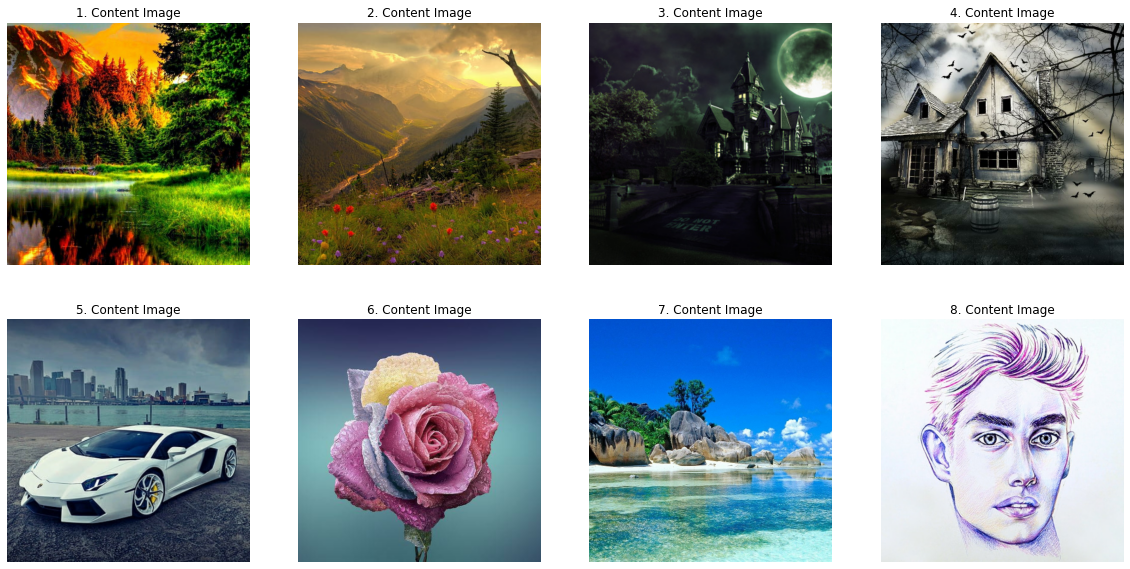

In [16]:
# show_content_images method of NeuralStyleTransfer will display the images (not more than 8)
nst.show_content_images()

Cleanup called...


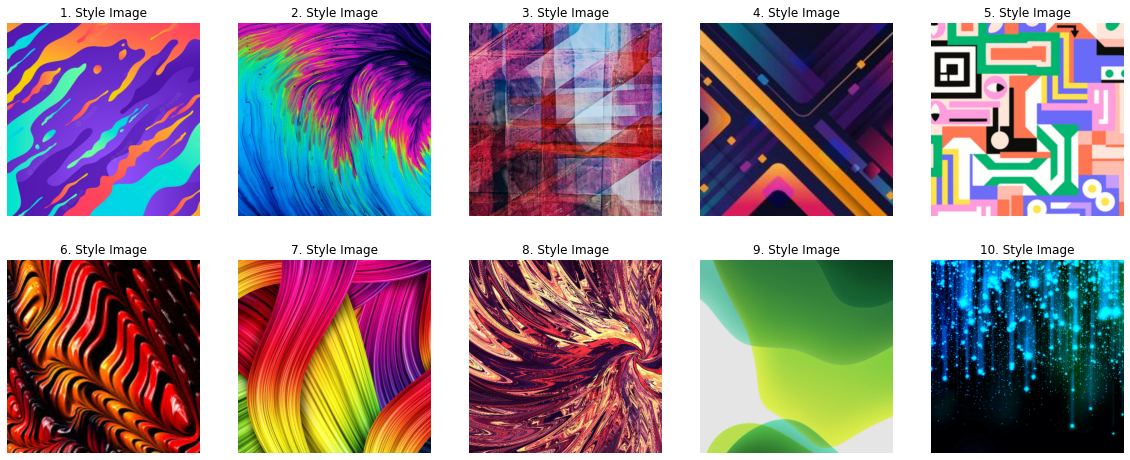

In [15]:
# show_style_images method of NeuralStyleTransfer will display the images (not more than 10)
nst.show_style_images()

### Image Generation

`generate()` of `NeuralStyleTransfer` Object method generates a tuple `(stylized image, generated_images_array)`.

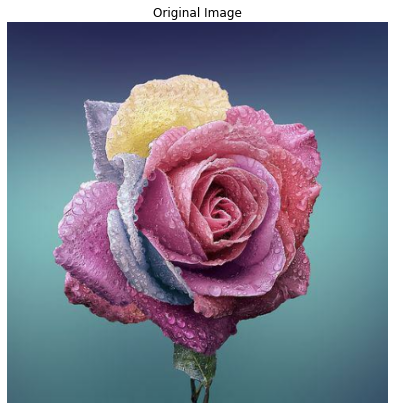


Epoch 1: 

100%|██████████| 100/100 [00:22<00:00,  4.37it/s]


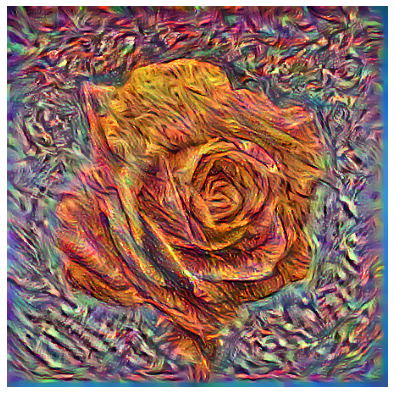


Epoch 2: 

100%|██████████| 100/100 [00:23<00:00,  4.32it/s]


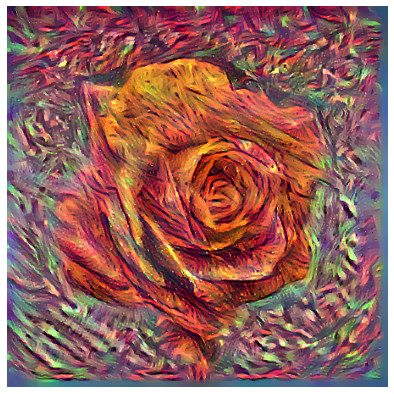


Epoch 3: 

100%|██████████| 100/100 [00:22<00:00,  4.42it/s]


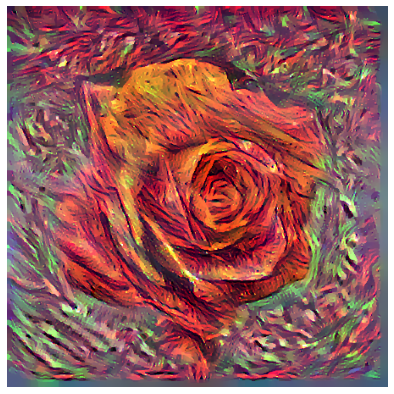


Epoch 4: 

100%|██████████| 100/100 [00:22<00:00,  4.36it/s]


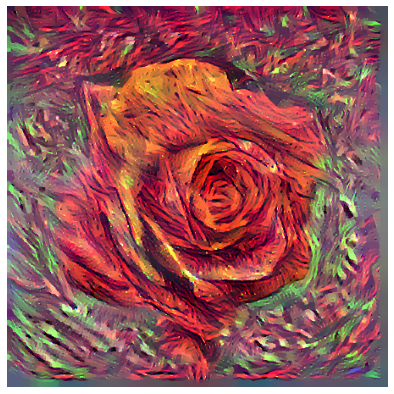


Epoch 5: 

100%|██████████| 100/100 [00:23<00:00,  4.33it/s]


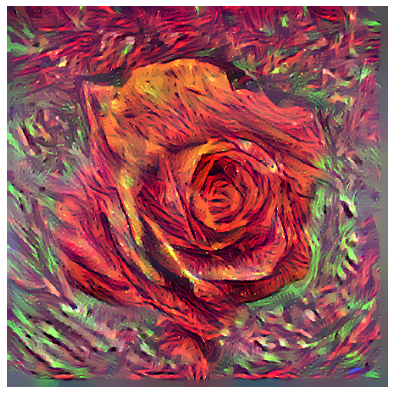


Epoch 6: 

100%|██████████| 100/100 [00:23<00:00,  4.33it/s]


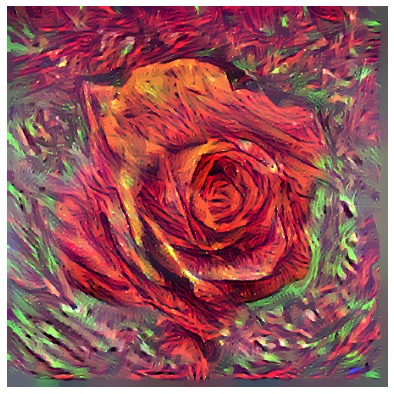


Epoch 7: 

100%|██████████| 100/100 [00:22<00:00,  4.36it/s]


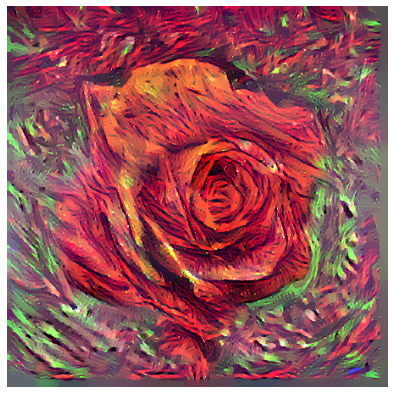


Epoch 8: 

100%|██████████| 100/100 [00:22<00:00,  4.35it/s]


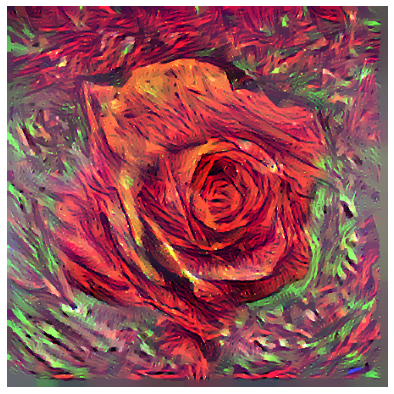


Epoch 9: 

100%|██████████| 100/100 [00:23<00:00,  4.27it/s]


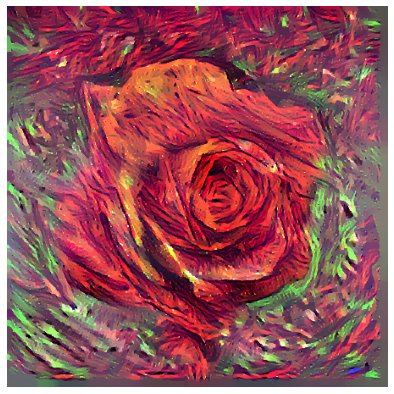


Epoch 10: 

100%|██████████| 100/100 [00:23<00:00,  4.29it/s]


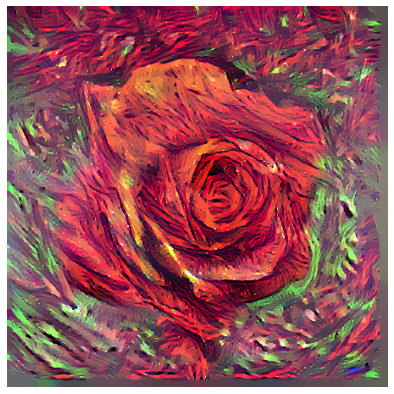

In [12]:
# get the stylized image and the image generated along the epochs
style_transfer_image, images_arr = nst.generate(epochs=10, steps_per_epoch=100)   # per epoch there are 100 optimization steps

## Results

**To save and display a gif of generated stylized images by epoch, `create_display_gif()` is used.**

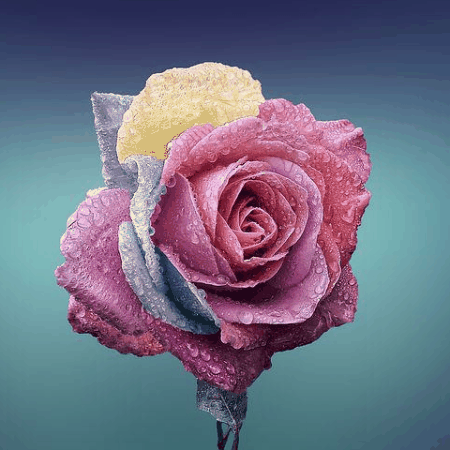

In [13]:
# save and display the gif
nst.create_display_gif(images_arr, "style_transfer_6_8.gif")